# <a id='toc1_'></a>[Tarea realizada por Carlos Sánchez Polo y Jesús Martínez Leal](#toc0_)
Última edición: 17/02/2024

**Table of contents**<a id='toc0_'></a>    
- [Reconocimiento de caras](#toc2_)    
  - [Etapa inicial: carga de librerías, funciones útiles y de nuestro conjunto de datos](#toc2_1_)    
  - [PCA](#toc2_2_)    
    - [Entrenamiento del modelo de PCA para reconocimiento de caras](#toc2_2_1_)    
    - [Aplicación del modelo de PCA a las imágenes de test](#toc2_2_2_)    
  - [KPCA](#toc2_3_)    
    - [Entrenamiento del modelo de KPCA](#toc2_3_1_)    
    - [Aplicación del modelo de KPCA a las imágenes de test](#toc2_3_2_)    
  - [Conclusiones](#toc2_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Reconocimiento de caras](#toc0_)

## <a id='toc2_1_'></a>[Etapa inicial: carga de librerías, funciones útiles y de nuestro conjunto de datos](#toc0_)

El objetivo de este proyecto es el de encontrar las caras del dataset de train que más se parecen a las del dataset de test. Para ello utilizaremos PCA y KPCA.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
import timeit

from utils_func import get_faces, get_person_num, show_sample_faces, split_train_test,get_stats

- Fijamos el random_state en todo el documento.

In [2]:
rs = 0

Cargamos el dataset y vemos algunos aspectos interesantes de nuestros datos, como el tamaño de la cara (imagen) o el número de clases diferentes que existen. 

Además, preparamos nuestro conjunto de train y test.

In [3]:
faces = get_faces(zipfile_path="./data/Grp13Dataset.zip")

In [4]:
faceshape = list(faces.values())[0].shape
print("Face image shape:", faceshape)

Face image shape: (80, 70)


In [5]:
classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of images:", len(faces))

Number of classes: 41
Number of images: 410


In [6]:
facematrix = []
facelabel = []

training_set, testing_set = split_train_test(zipfilepath="./data/Grp13Dataset.zip")

- `Construye la matriz de datos como una matriz en la que cada fila se corresponde con una imagen y cada columna con los píxeles de las imágenes en 1D. Construye también el vector facelabel. `

In [7]:
# Construir las matrices "facematrix" y "facelabel"

start = timeit.default_timer()

for person, images in training_set.items(): # accedo a llaves, valores del diccionario de training
    
    image_flat = images.flatten() 
    facematrix.append(image_flat)
    facelabel.append(get_person_num(person))

    
stop = timeit.default_timer()
print("Time in seconds:", stop - start)

Time in seconds: 0.001065099999323138


👀 Revisando `utils_func.py`, es fácil ver que la función `split_train_test()` hace que las imágenes 0 y 1 de cada persona vayan al conjunto de testing.

## <a id='toc2_2_'></a>[PCA](#toc0_)

### <a id='toc2_2_1_'></a>[Entrenamiento del modelo de PCA para reconocimiento de caras](#toc0_)

- `Realiza la PCA. Haz pruebas con diferente número de componentes comprobando el error en el acierto.`

⚠️ No hace falta quitar la media de las imágenes, ya que `PCA()` de sklearn lo hace por nosotros. Esto se ve en el enlace: https://github.com/scikit-learn/scikit-learn/blob/6eff1757e/sklearn/decomposition/_pca.py#L431.

In [8]:
facematrix_np = np.array(facematrix)

mean_image = np.mean(facematrix_np, axis = 0) # se pone axis = 0 puesto que así se hace la media de cada columna

#facematrix_centered = facematrix_np - mean_image
facematrix_centered = facematrix_np

Se representa a continuación la cara media.

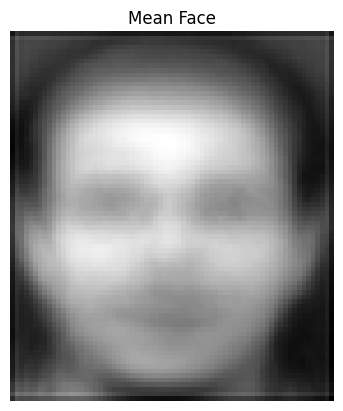

In [9]:
mean_face = mean_image.reshape(faceshape)


plt.imshow(mean_face, cmap = 'gray')
plt.title('Mean Face')
plt.axis('off')
plt.show()

Esta imagen nos da una primera visión de lo que son las características faciales comunes encontradas en las imágenes de entrada.

- `Representa las primeras "eigenfaces" en escala de grises utilizando un subplot. `

Antes de representarlas, evaluamos cuántas componentes debe tener nuestro modelo de PCA para reducir dimensionalidad manteniendo una cantidad de información razonable sobre nuestros datos.

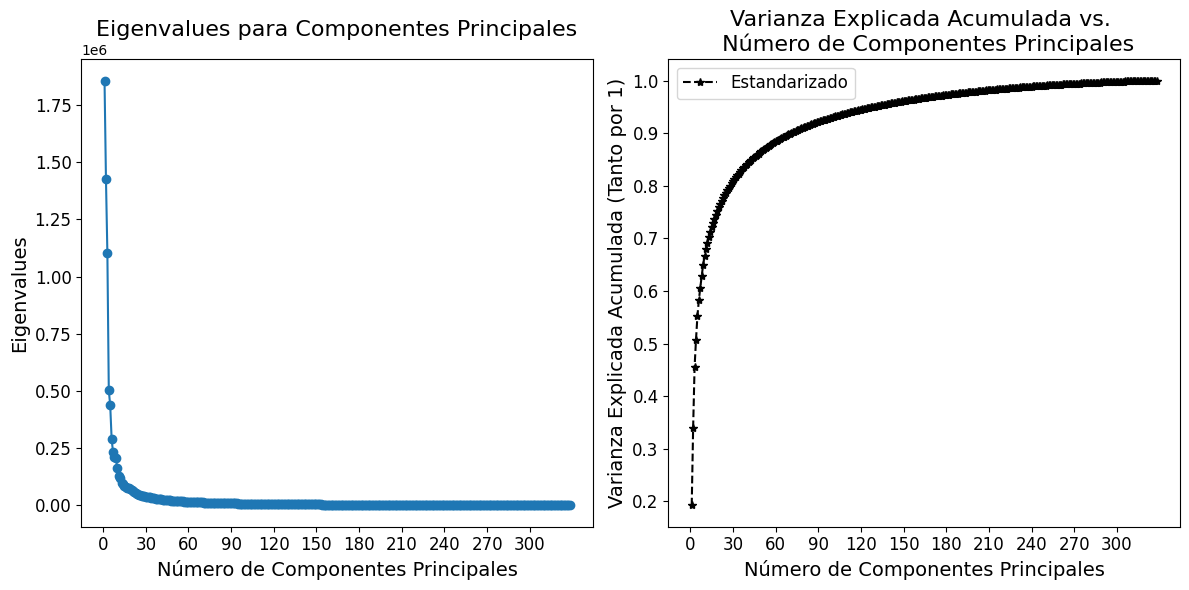

In [10]:
pca = PCA(random_state = rs)
pca.fit(facematrix_centered)


eigenvalues = pca.explained_variance_

# Varianza explicada acumulada
cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
num_components = np.arange(1, len(cumulative_variance_explained) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de autovalores

axs[0].plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
axs[0].set_xlabel('Número de Componentes Principales', fontsize=14)
axs[0].set_ylabel('Eigenvalues', fontsize=14)
axs[0].set_title('Eigenvalues para Componentes Principales', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=12)  
axs[0].set_xticks(np.arange(0, len(eigenvalues) + 1, 30))  

# Gráfico de varianza explicada acumulada

axs[1].plot(num_components, cumulative_variance_explained, linestyle='--', marker='*', color='black', label='Estandarizado')
axs[1].set_xlabel('Número de Componentes Principales', fontsize=14)
axs[1].set_ylabel('Varianza Explicada Acumulada (Tanto por 1)', fontsize=14)
axs[1].legend(fontsize=12)
axs[1].set_title('Varianza Explicada Acumulada vs. \n Número de Componentes Principales', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=12)  
axs[1].set_xticks(np.arange(0, len(eigenvalues) + 1, 30)) 

plt.tight_layout()


plt.show()

Nos quedaremos con un número de componentes principales de tal forma que se explique el 95% de la varianza.

In [11]:
num_components = np.argmax(cumulative_variance_explained >= 0.95) + 1
print(f"Se selecciona un total de {num_components} componentes principales.")

Se selecciona un total de 129 componentes principales.


- `Obtención de las eigenfaces.`

In [12]:
pca = PCA(n_components = num_components, random_state = rs, svd_solver = 'full') # modelo de PCA de reducción de dimensionalidad

pca.fit(facematrix_centered)

eigenfaces = pca.components_ #.reshape(-1, *faceshape): están ordenados en orden decreciente de explained_variance_

Lo que devuelve `.components_` es un número de vectores igual a `n_components` en el espacio original que explican la mayor varianza de nuestros datos. 

Como resultado, ya que estamos cogiendo un número inferior a la dimensionalidad del espacio original, estamos reduciendo dimensionalidad.

- `Representación de las eigenfaces.`

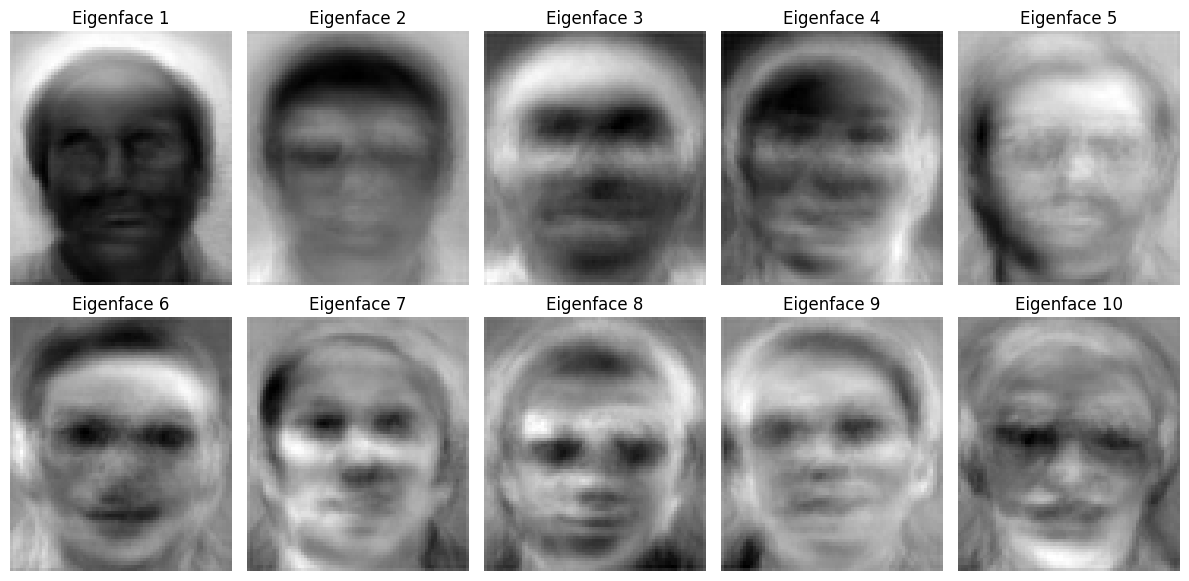

In [13]:
num_eigenfaces = 10 # número a mostrar en el plot

plt.figure(figsize=(12, 6))
for i in range(num_eigenfaces):
    eigenface = pca.components_[i].reshape(faceshape)  # Reshape del autovector a la forma de la imagen
    plt.subplot(2, 5, i + 1)
    plt.imshow(eigenface, cmap = 'gray')
    plt.title('Eigenface {}'.format(i + 1))
    plt.axis('off')

plt.tight_layout()
plt.show()

### <a id='toc2_2_2_'></a>[Aplicación del modelo de PCA a las imágenes de test](#toc0_)

- `Completar la función *get_best_match()* para que compare la PCA de train con la PCA de las imágenes de test. Calcula la distancia euclídea entre ambas con la función *np.linalg.norm*.`

Se han añadido argumentos adicionales de `plot` y `text` por comodidad posterior.

In [14]:
def get_best_match(filename, pca, plot = True, text = True):
    query = faces[filename].reshape(1, -1)
    
    pca_train = pca.transform(facematrix_centered)
    pca_query = pca.transform(query) # calculamos la proyección al espacio de menor dimensionalidad para una cara en concreto
    
    euclidean_distance = np.linalg.norm(pca_query - pca_train, axis = 1) # vector con distancias; en facelabel está el orden de las personas de pca_train
    
    best_match = np.argmin(euclidean_distance) 
    
    if text:
        print("Best match %s with Euclidean distance %f" %  (facelabel[best_match], euclidean_distance[best_match]))
    
    person_num, img_num = get_person_num(filename=filename)
    
    if plot:
        fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))

        axes[0].imshow(query.reshape(faceshape), cmap="gray")
        axes[0].set_title("Query - Person " + str(person_num))
        axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
        axes[1].set_title("Best match - Person " + str((best_match//8) + 1)) # el 8 es porque hay 8 fotos de train para cada persona
        plt.show()
    
    return (((best_match // 8) + 1), person_num) # predicha y el verdadero, básicamente

- `Llama a la función *get_best_match* y contabiliza las predicciones totales, las correctas y las falsas.`

⚠️ Si se desean ver los plot que retorna la función get_best_match es necesario establecer el parámetro `plot` en `True` en la llamada de abajo.

Best match (1, 5) with Euclidean distance 2321.855365


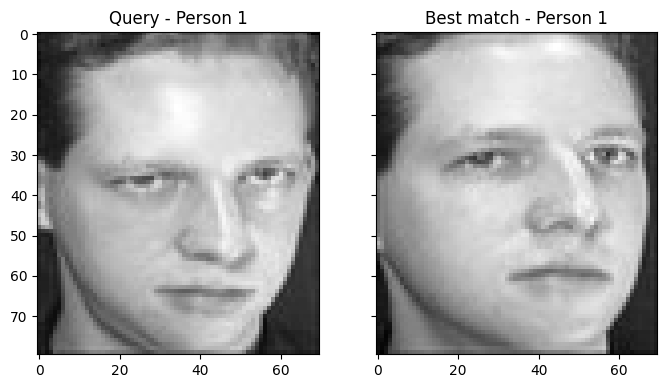

Best match (1, 7) with Euclidean distance 2189.345049


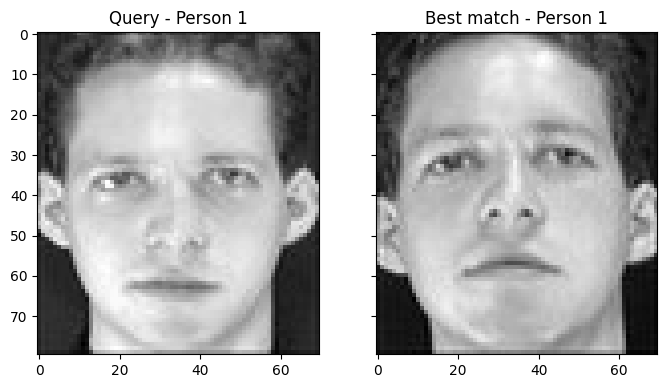

Best match (2, 3) with Euclidean distance 1255.454395


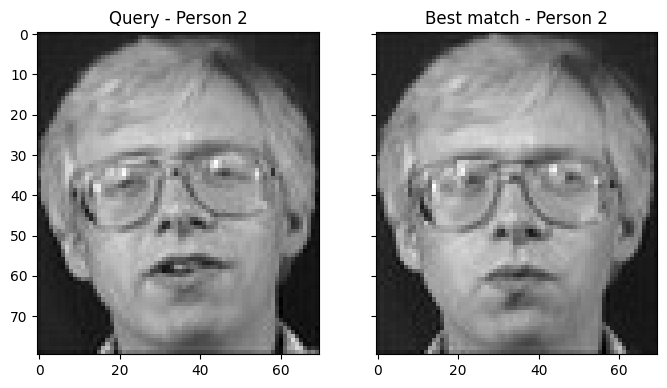

Best match (2, 8) with Euclidean distance 1124.678441


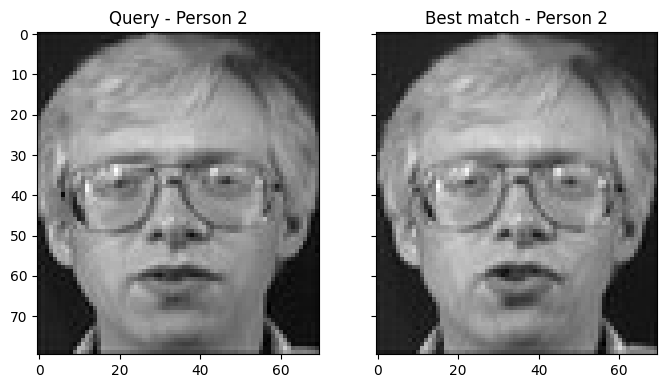

Best match (3, 3) with Euclidean distance 1614.600039


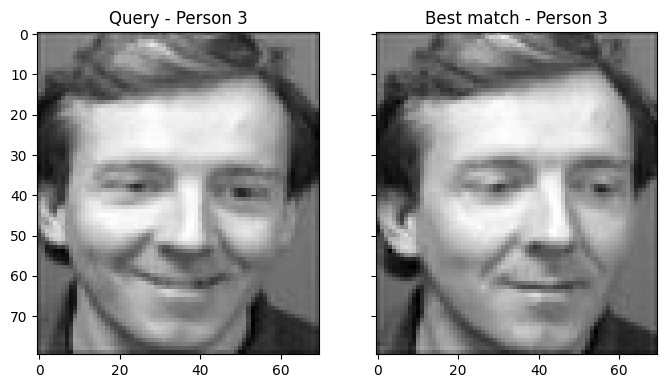

Best match (3, 9) with Euclidean distance 967.222270


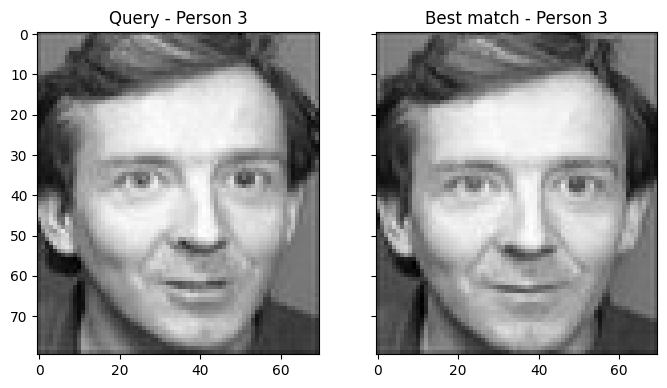

Best match (4, 8) with Euclidean distance 1258.484554


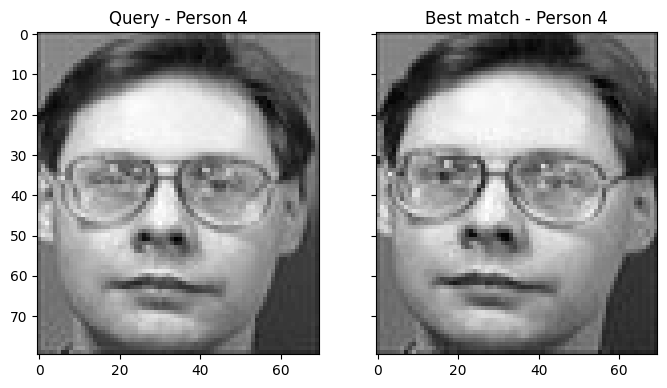

Best match (4, 5) with Euclidean distance 1274.307253


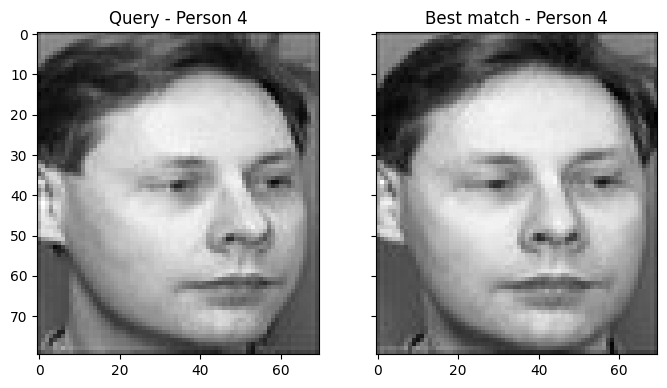

Best match (5, 4) with Euclidean distance 593.723678


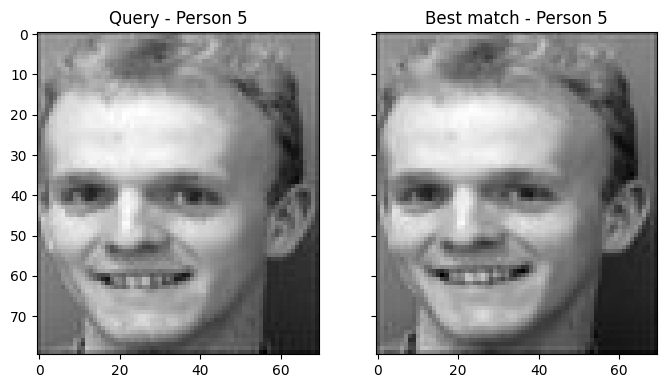

Best match (40, 5) with Euclidean distance 1576.954557


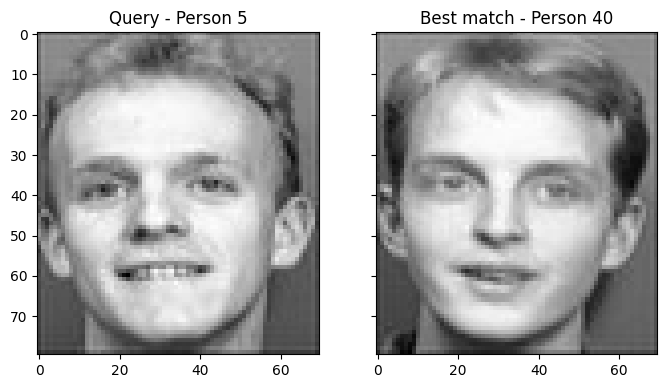

Best match (6, 3) with Euclidean distance 859.562540


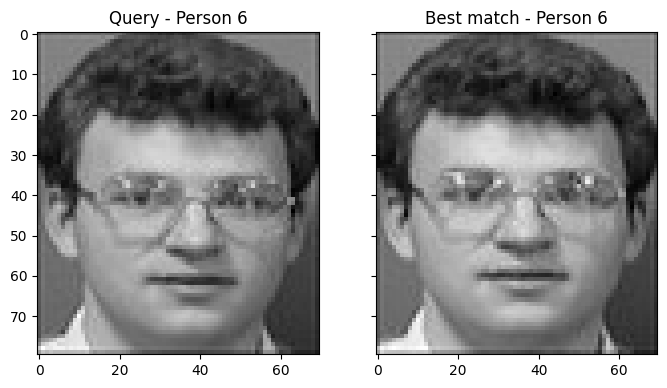

Best match (6, 4) with Euclidean distance 655.674068


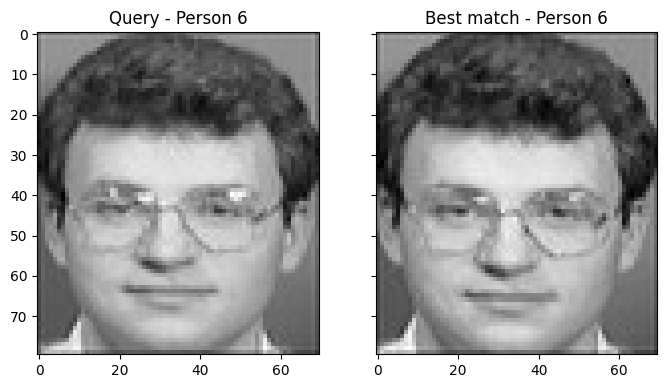

Best match (7, 3) with Euclidean distance 1244.048116


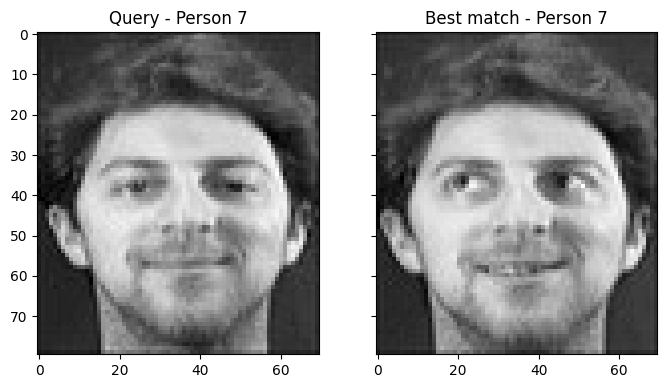

Best match (7, 5) with Euclidean distance 1538.583910


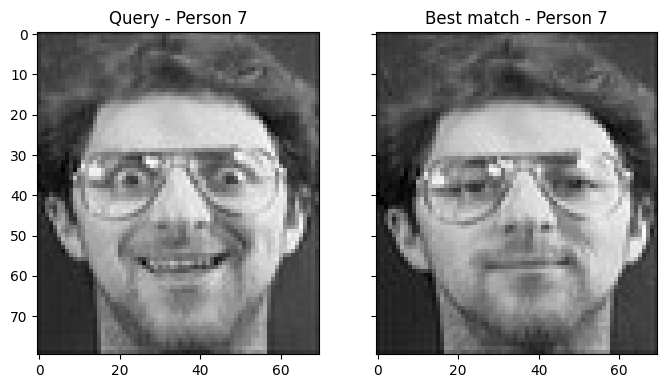

Best match (8, 2) with Euclidean distance 966.006730


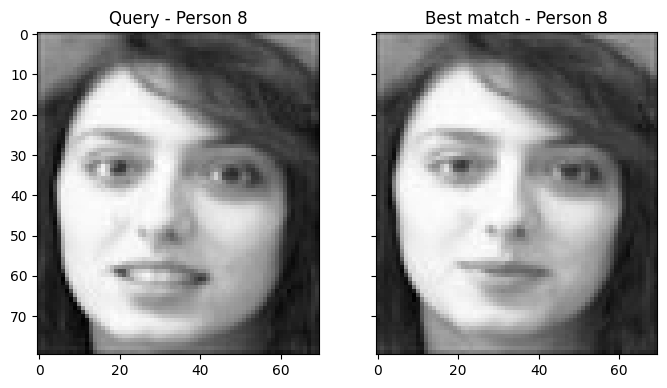

Best match (8, 3) with Euclidean distance 1250.770329


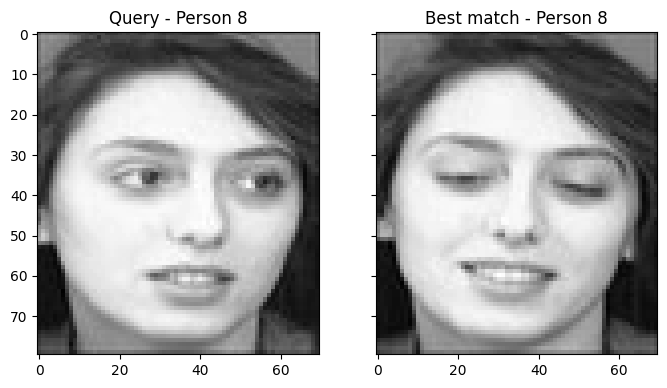

Best match (9, 3) with Euclidean distance 936.076230


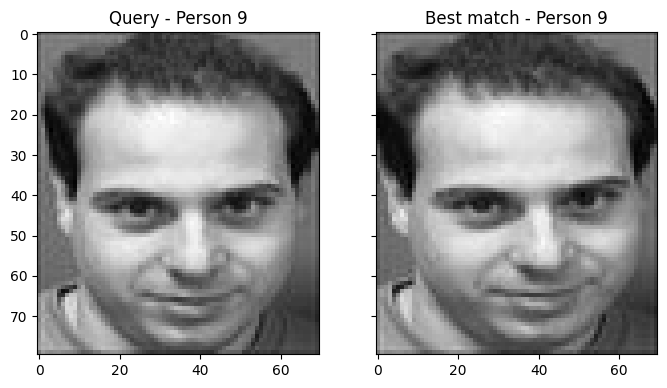

Best match (9, 5) with Euclidean distance 1584.364260


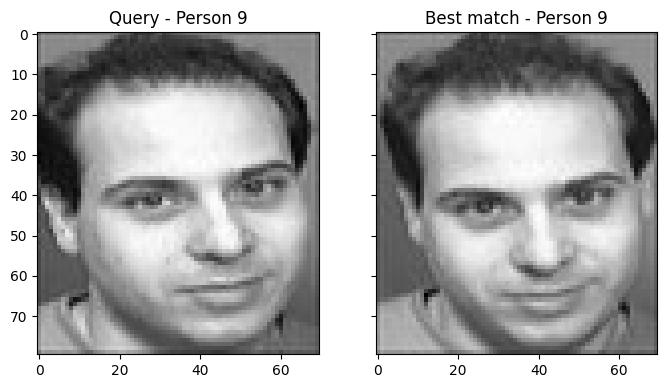

Best match (38, 4) with Euclidean distance 2472.351114


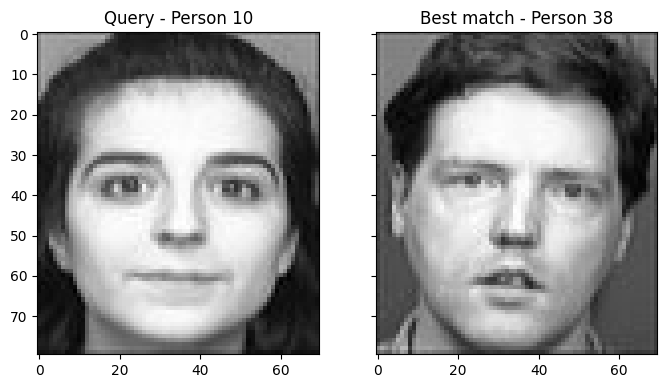

Best match (10, 2) with Euclidean distance 1775.689033


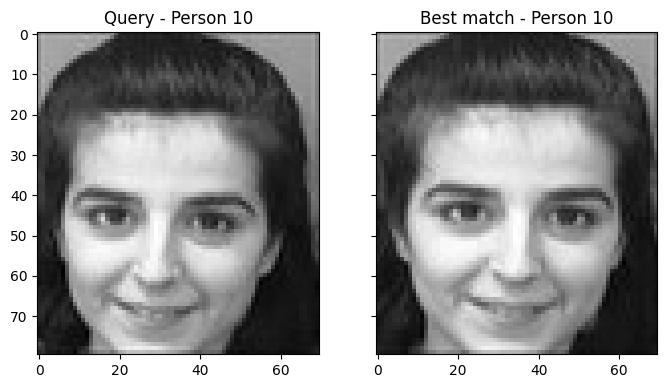

Best match (11, 3) with Euclidean distance 1359.148317


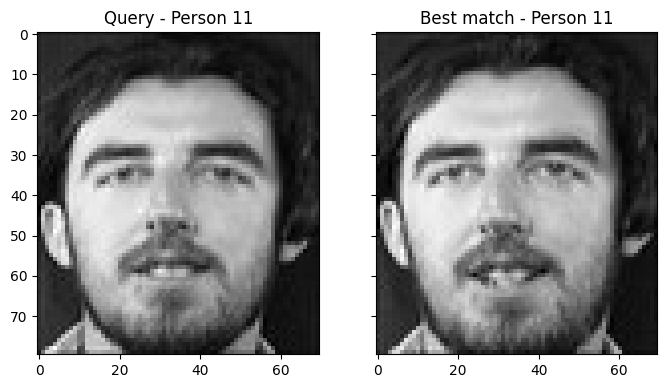

Best match (11, 7) with Euclidean distance 1530.942924


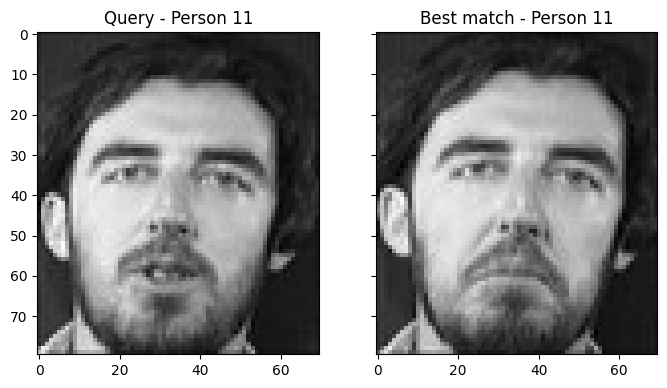

Best match (12, 8) with Euclidean distance 1543.220933


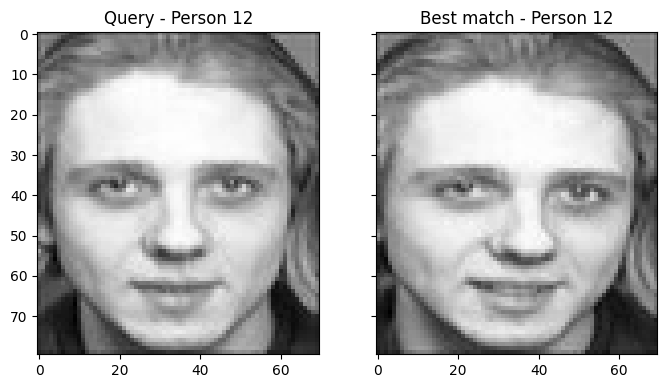

Best match (12, 9) with Euclidean distance 1141.842479


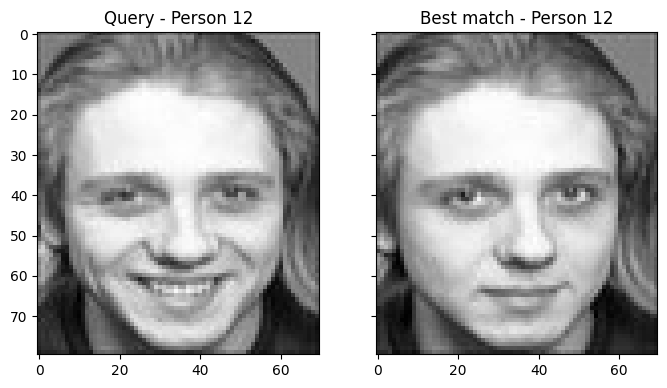

Best match (13, 2) with Euclidean distance 1082.786524


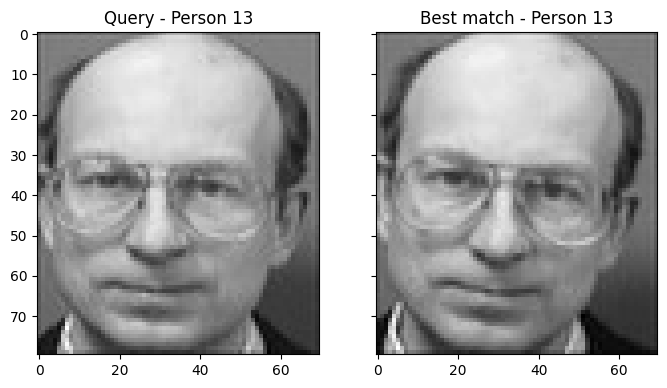

Best match (13, 5) with Euclidean distance 693.747902


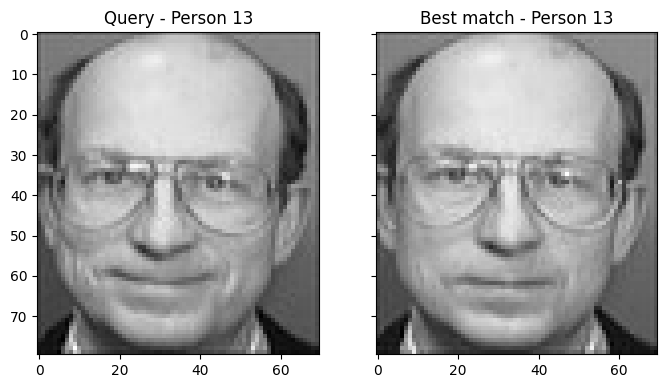

Best match (14, 4) with Euclidean distance 1291.022715


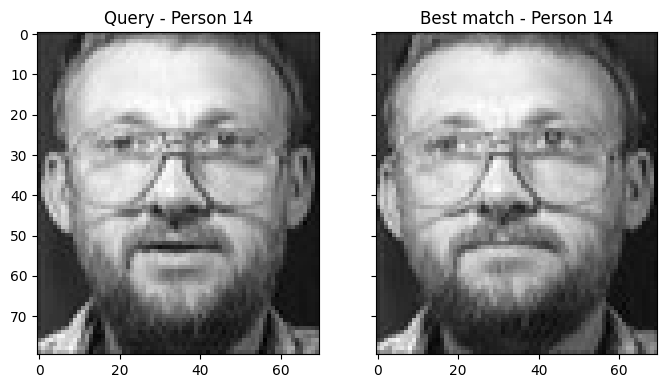

Best match (14, 9) with Euclidean distance 2097.605751


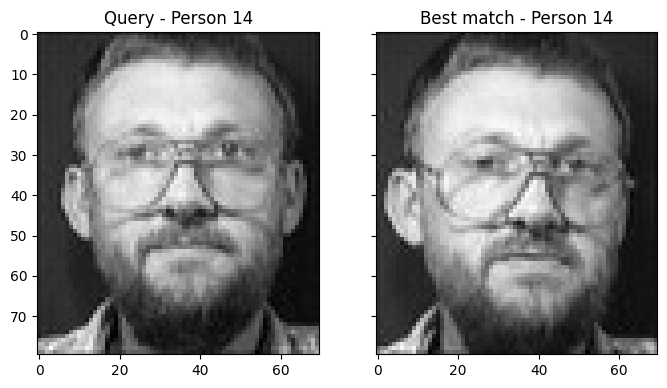

Best match (15, 3) with Euclidean distance 672.828450


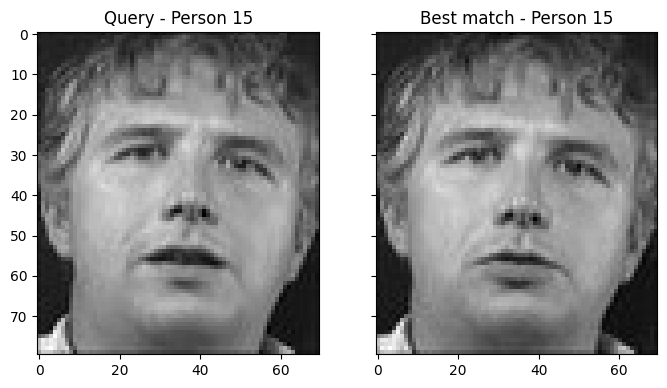

Best match (15, 5) with Euclidean distance 930.496857


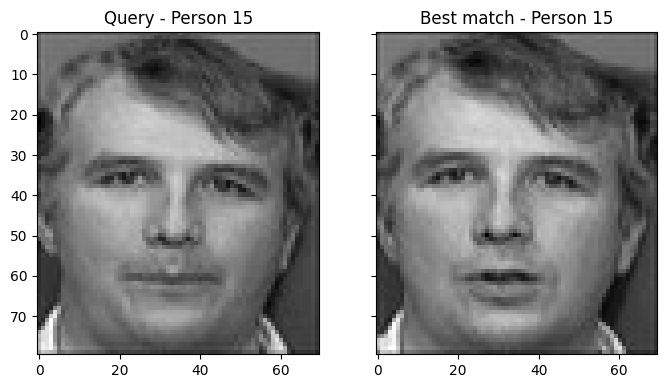

Best match (16, 6) with Euclidean distance 2186.614691


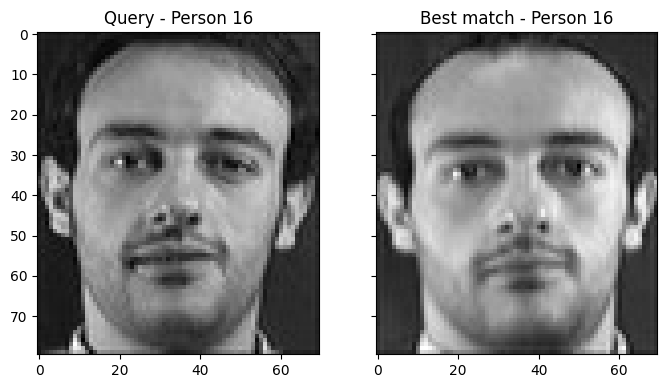

Best match (16, 3) with Euclidean distance 1560.059059


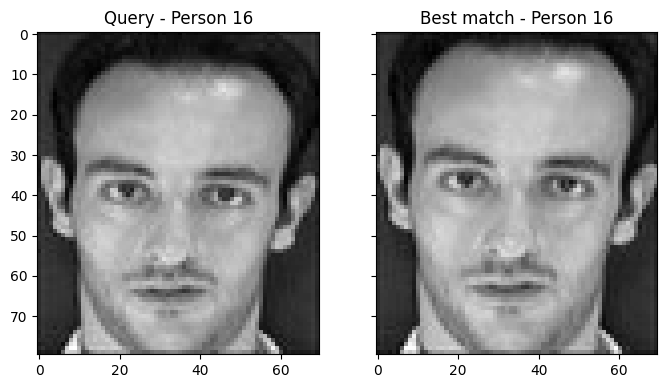

Best match (17, 5) with Euclidean distance 926.476999


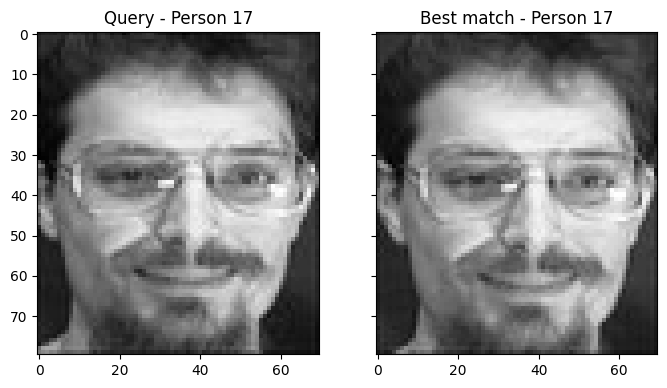

Best match (17, 7) with Euclidean distance 1030.412439


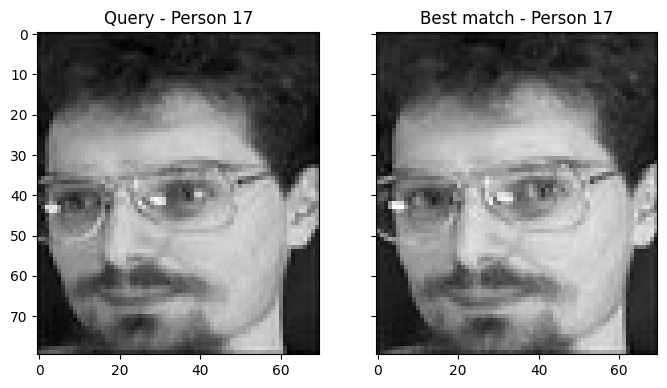

Best match (18, 2) with Euclidean distance 1229.042663


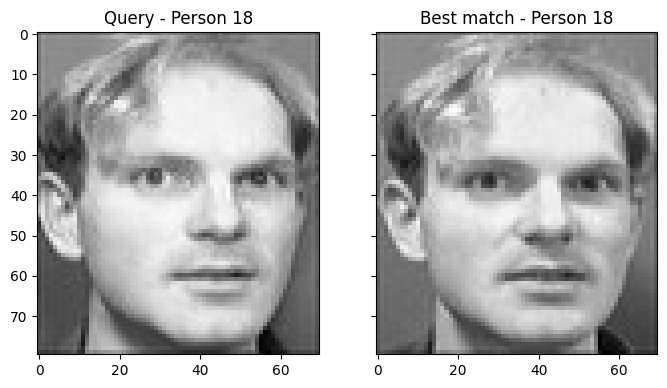

Best match (18, 6) with Euclidean distance 1463.339218


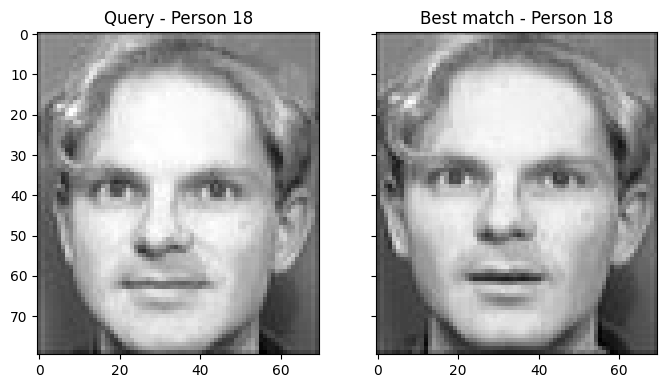

Best match (19, 2) with Euclidean distance 783.122786


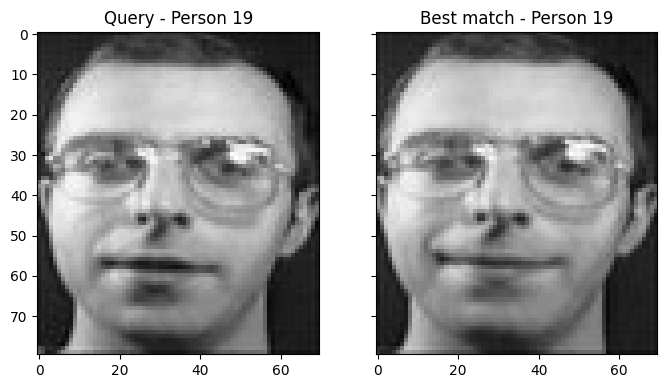

Best match (19, 2) with Euclidean distance 1383.590261


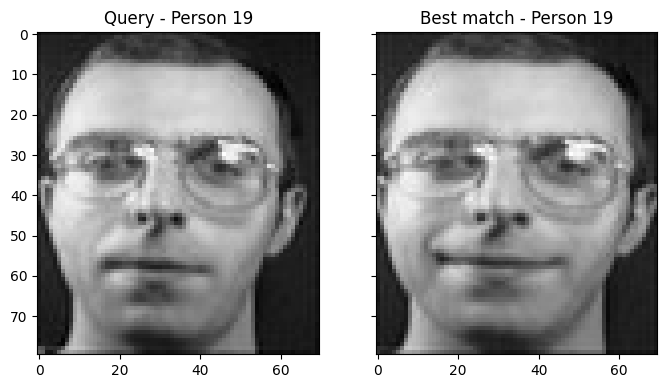

Best match (20, 2) with Euclidean distance 952.927330


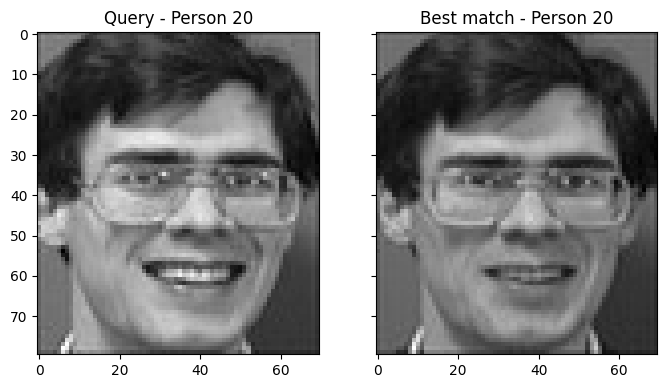

Best match (20, 2) with Euclidean distance 979.178977


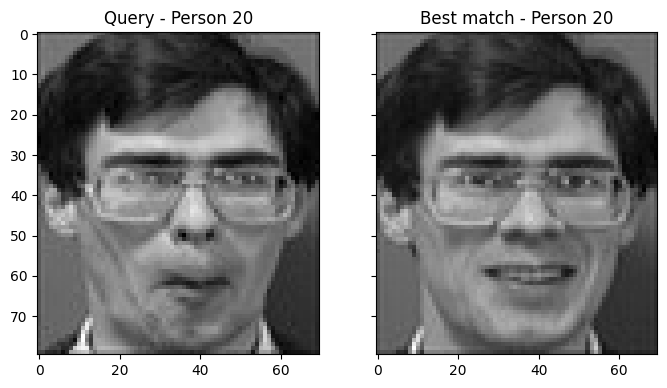

Best match (21, 5) with Euclidean distance 1466.163663


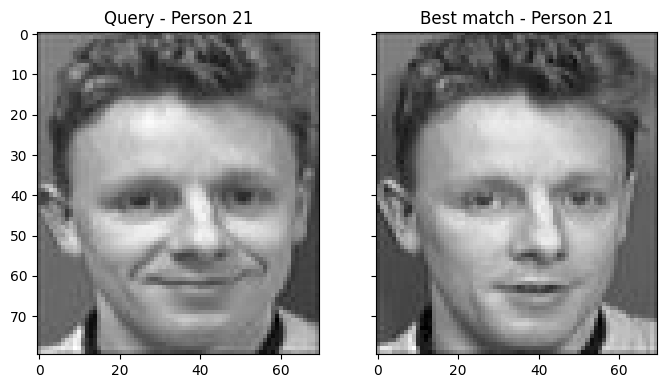

Best match (21, 8) with Euclidean distance 1006.110113


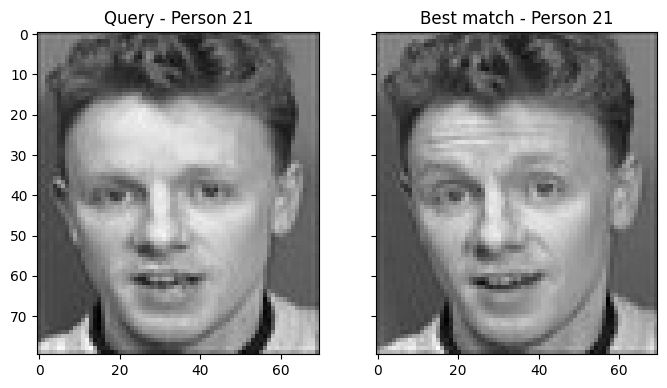

Best match (22, 9) with Euclidean distance 938.686405


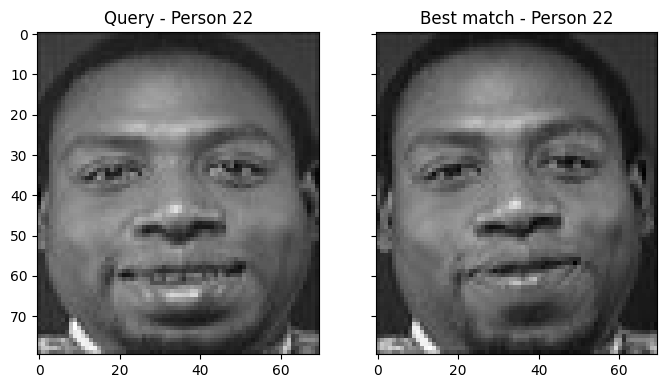

Best match (22, 2) with Euclidean distance 998.303993


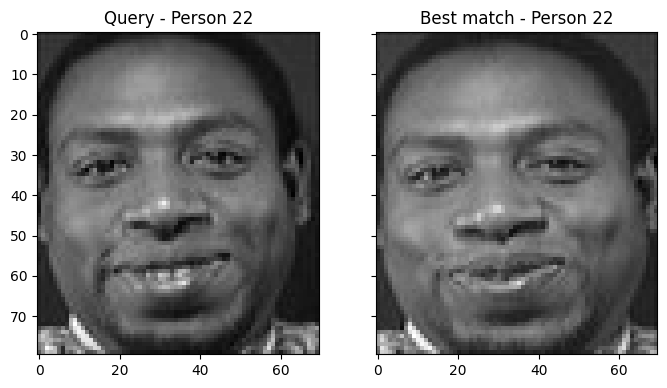

Best match (23, 9) with Euclidean distance 1752.219677


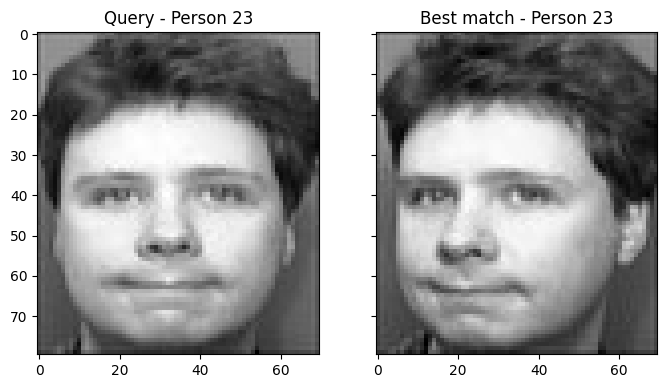

Best match (23, 9) with Euclidean distance 1425.885436


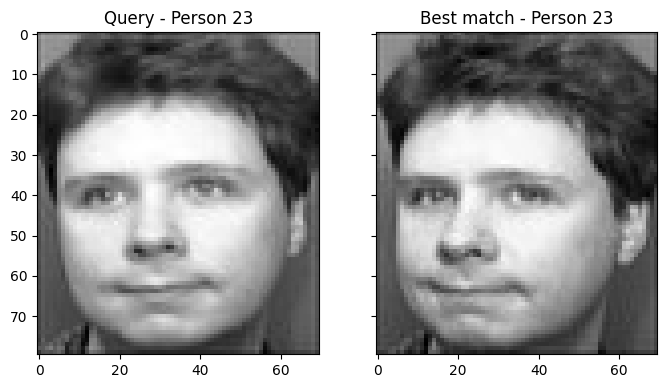

Best match (24, 2) with Euclidean distance 946.024751


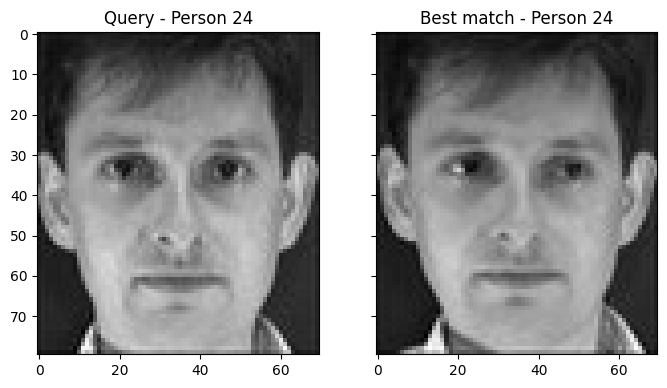

Best match (24, 9) with Euclidean distance 1163.559044


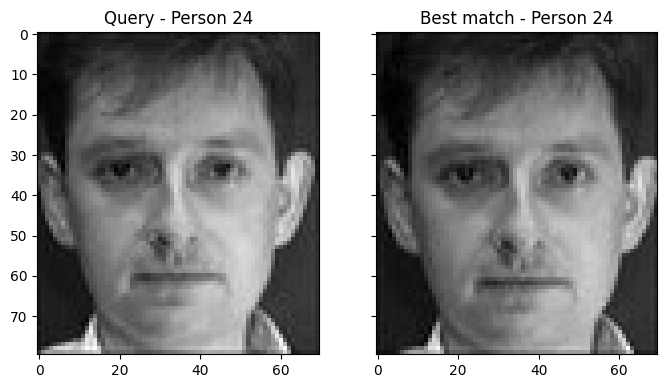

Best match (25, 3) with Euclidean distance 1122.531018


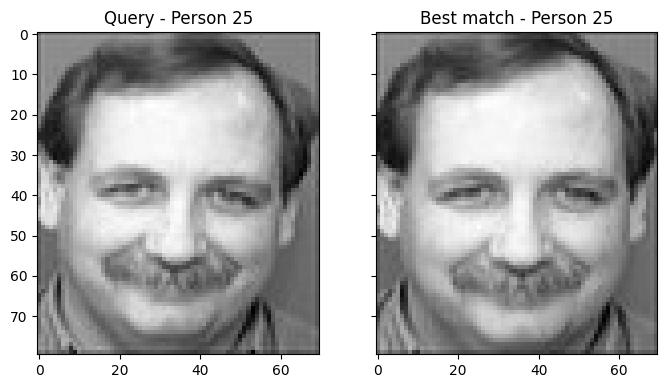

Best match (25, 3) with Euclidean distance 1008.887065


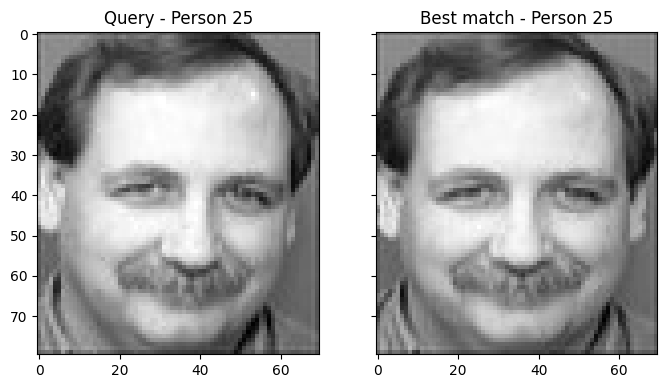

Best match (26, 6) with Euclidean distance 1416.449762


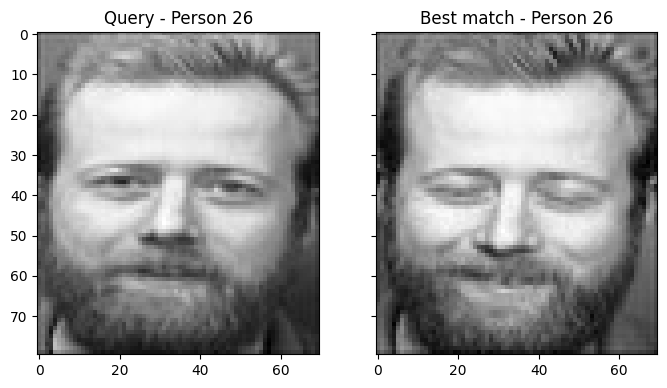

Best match (26, 8) with Euclidean distance 622.402624


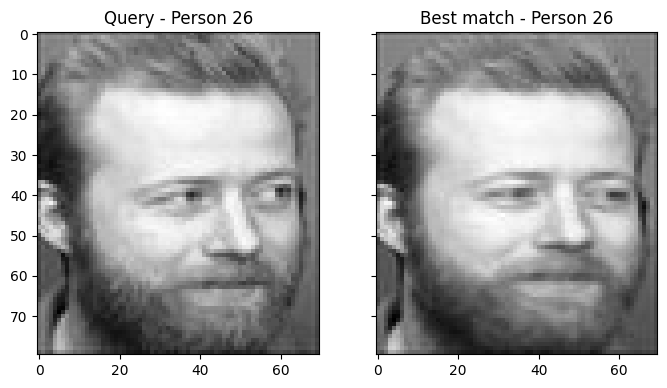

Best match (27, 4) with Euclidean distance 805.195345


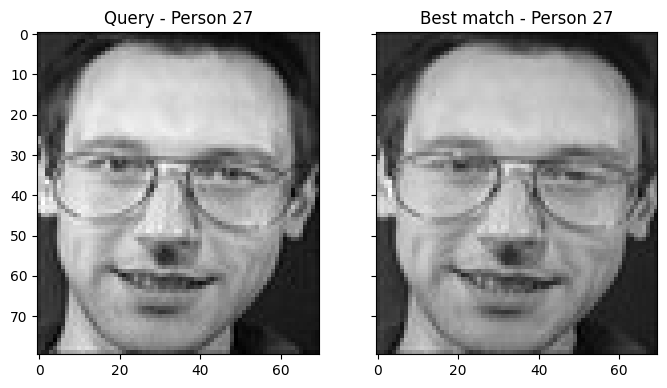

Best match (27, 5) with Euclidean distance 1754.941528


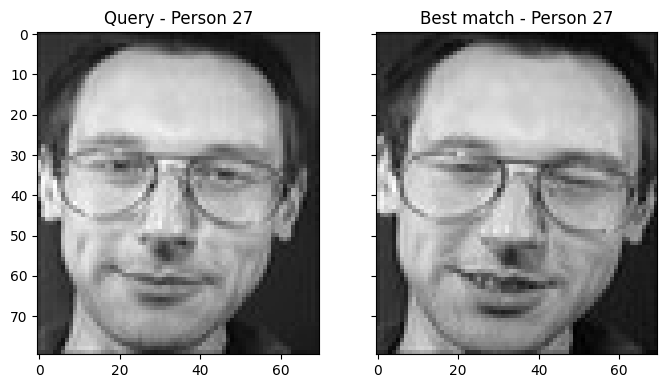

Best match (28, 6) with Euclidean distance 680.728874


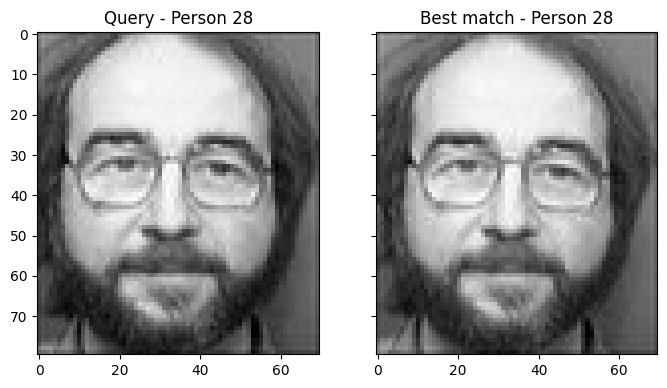

Best match (28, 3) with Euclidean distance 1731.805425


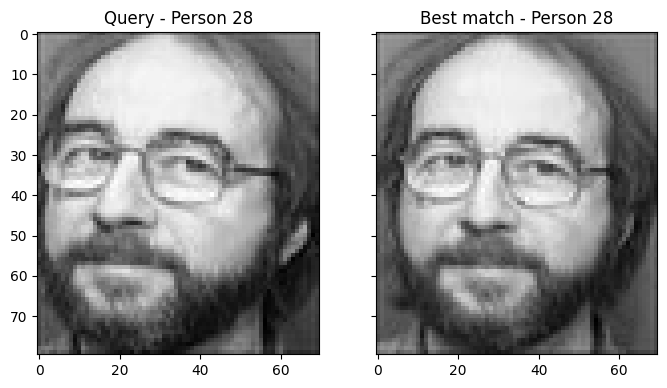

Best match (29, 3) with Euclidean distance 1060.719431


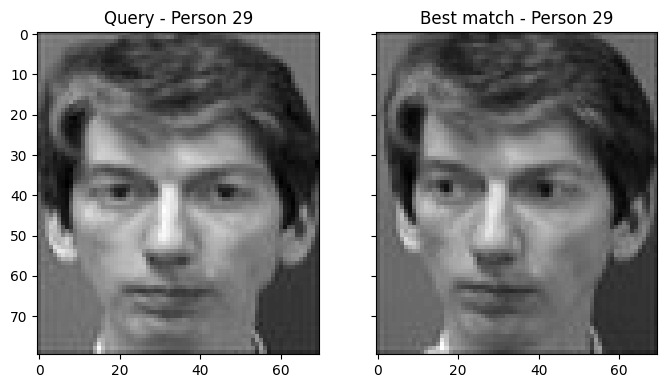

Best match (29, 3) with Euclidean distance 1363.547747


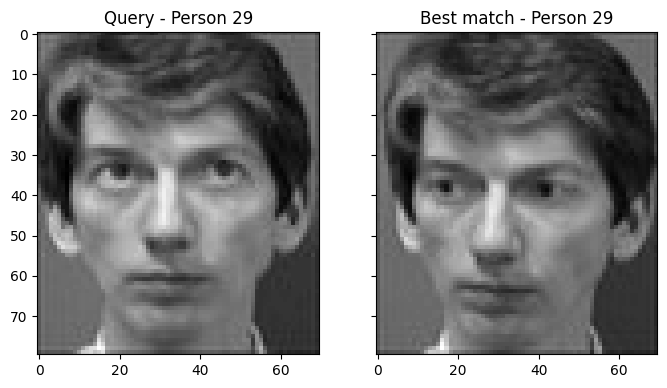

Best match (30, 2) with Euclidean distance 1173.533853


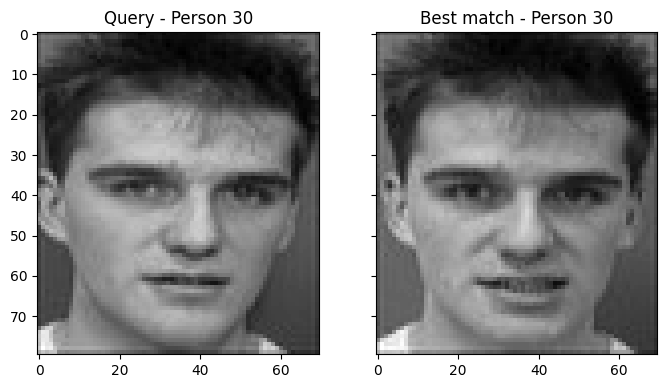

Best match (30, 2) with Euclidean distance 1157.960946


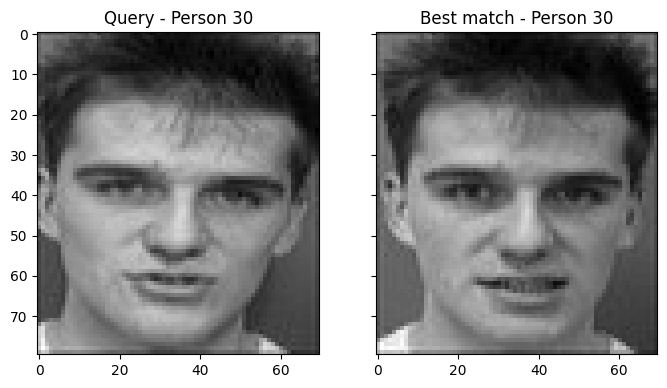

Best match (31, 8) with Euclidean distance 1011.895270


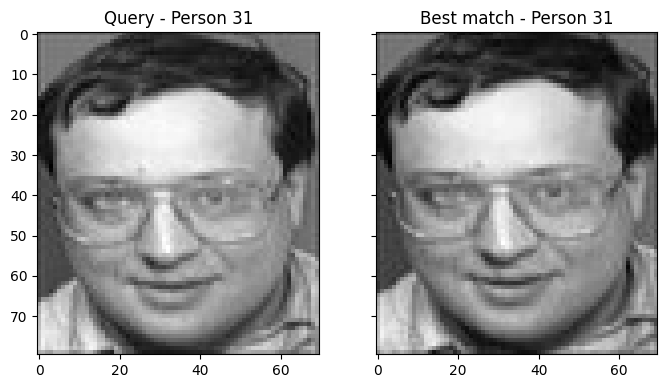

Best match (31, 5) with Euclidean distance 1211.027499


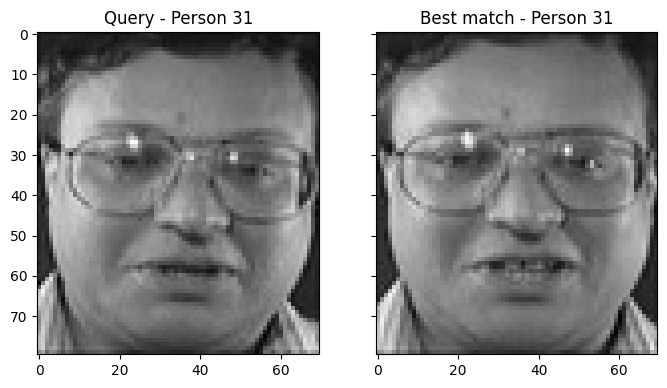

Best match (32, 5) with Euclidean distance 1741.721516


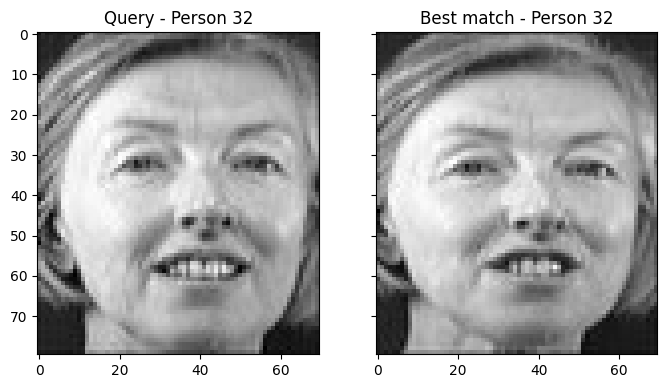

Best match (32, 6) with Euclidean distance 1274.057181


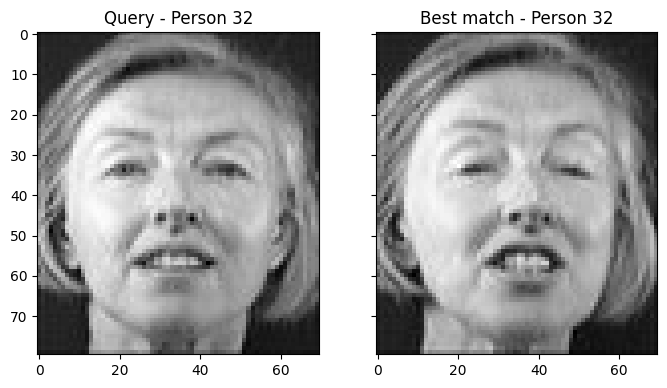

Best match (33, 3) with Euclidean distance 1634.372417


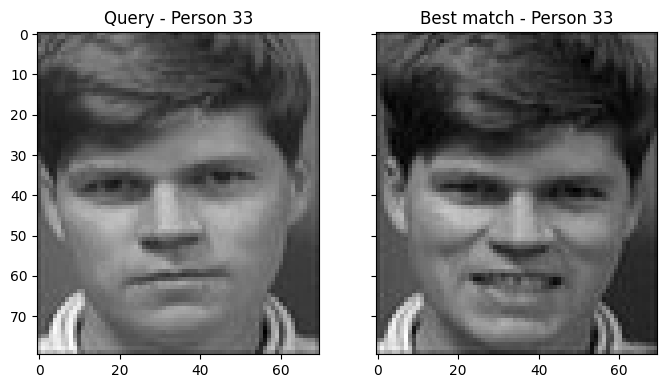

Best match (33, 2) with Euclidean distance 398.929038


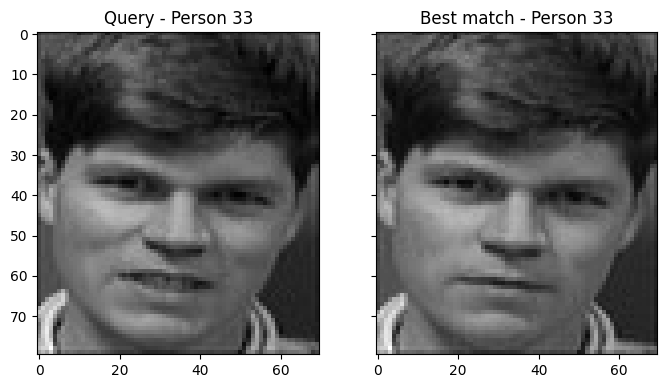

Best match (34, 6) with Euclidean distance 1142.089739


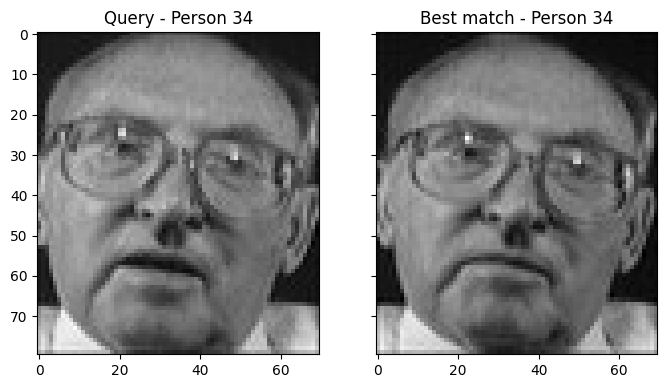

Best match (34, 9) with Euclidean distance 684.082520


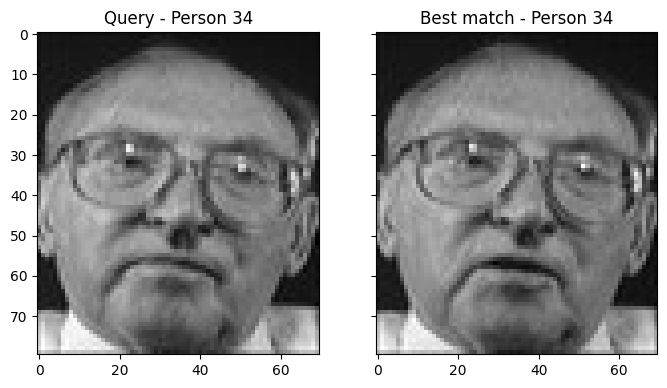

Best match (40, 6) with Euclidean distance 2412.351844


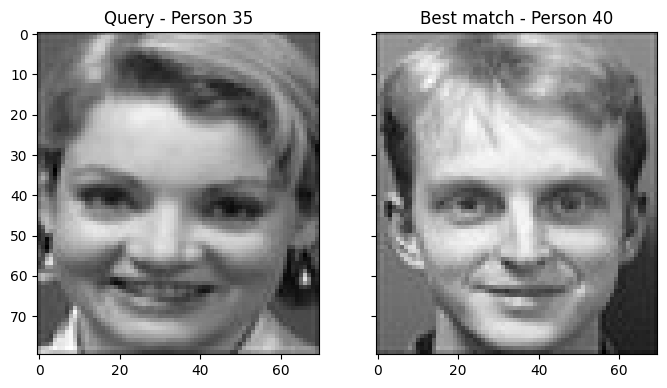

Best match (35, 5) with Euclidean distance 1821.734677


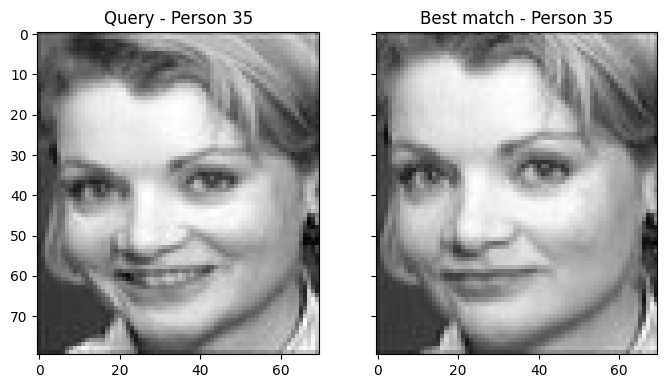

Best match (36, 5) with Euclidean distance 1563.442611


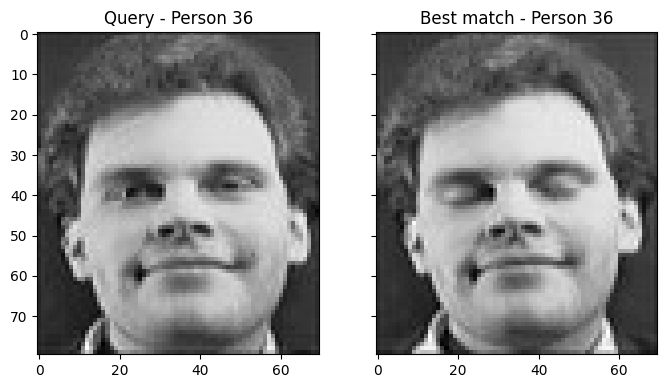

Best match (36, 6) with Euclidean distance 2055.932740


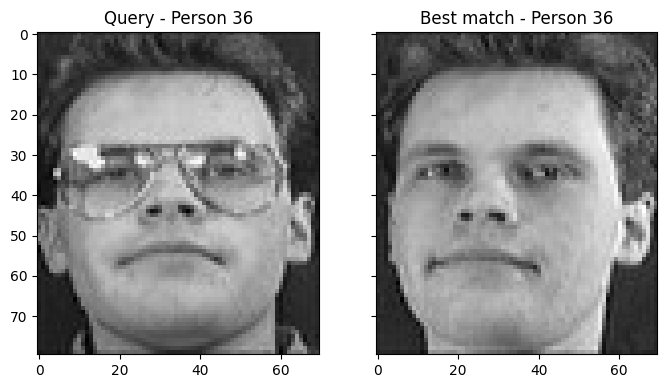

Best match (37, 9) with Euclidean distance 735.093264


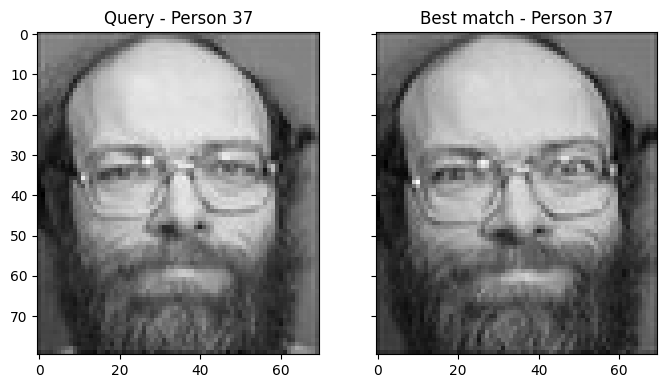

Best match (37, 9) with Euclidean distance 1035.204497


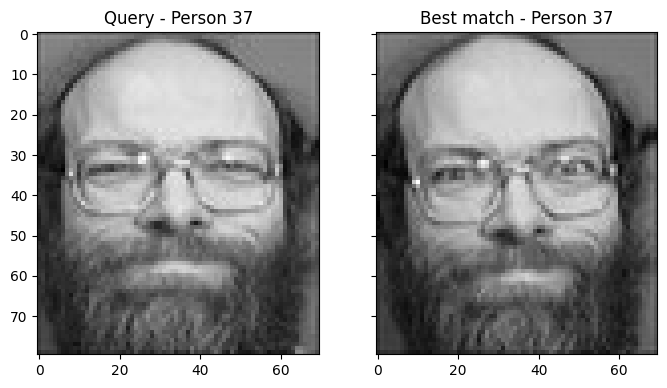

Best match (38, 6) with Euclidean distance 1034.323734


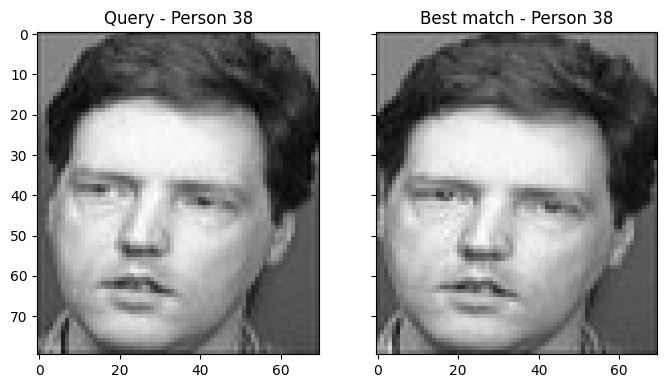

Best match (38, 5) with Euclidean distance 926.275189


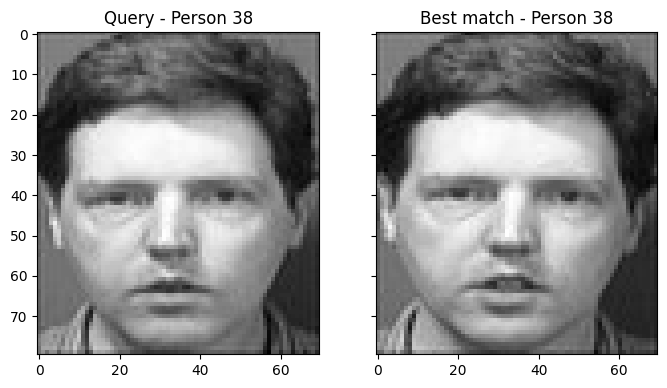

Best match (39, 2) with Euclidean distance 1475.186491


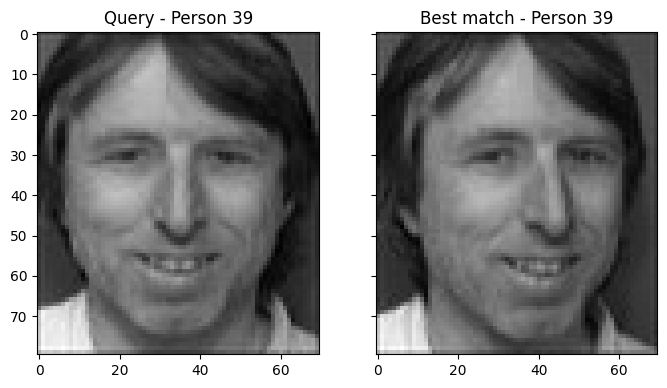

Best match (39, 6) with Euclidean distance 1619.090884


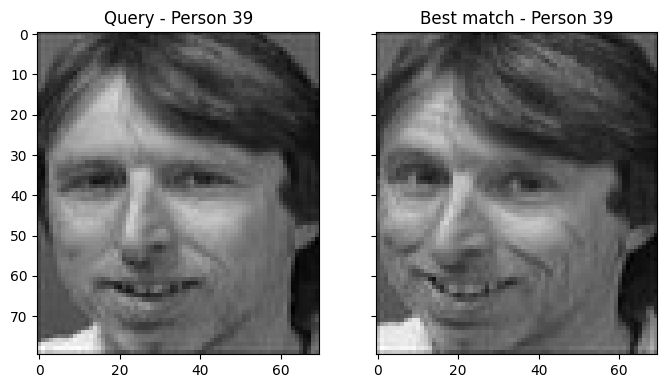

Best match (40, 8) with Euclidean distance 1532.370400


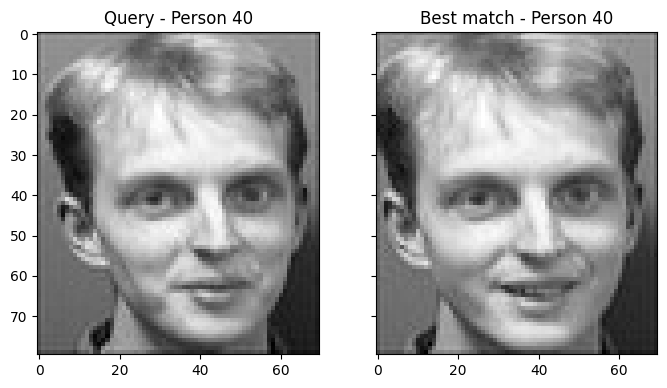

Best match (40, 4) with Euclidean distance 1599.414509


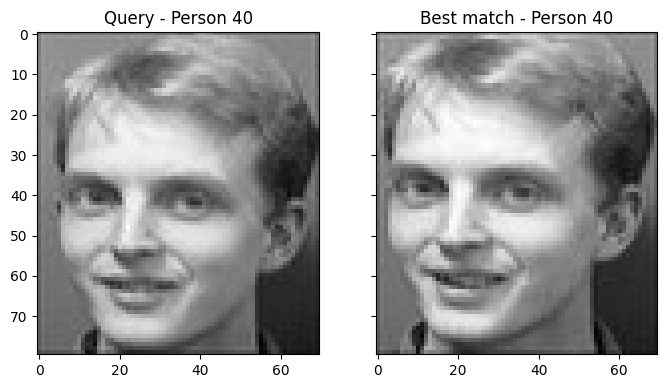

Best match (41, 2) with Euclidean distance 3213.336971


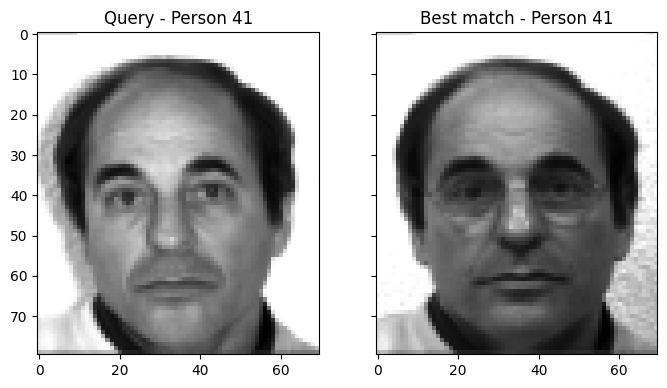

Best match (41, 8) with Euclidean distance 1696.662161


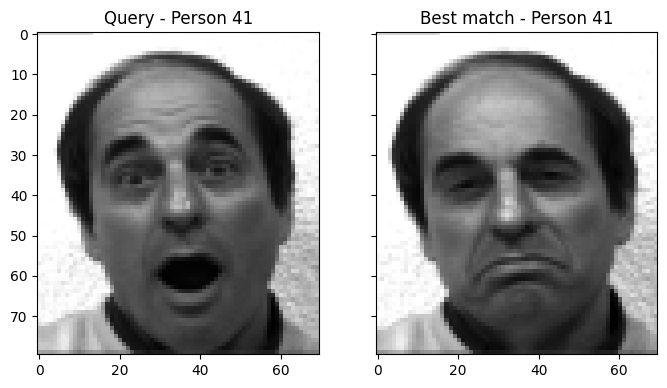

In [15]:
stop = timeit.default_timer()

correct_pred = 0
wrong_pred = 0
total_pred = 0

for key, val in testing_set.items(): 

    total_pred += 1
    
    predicted, actual = get_best_match(filename = key, pca = pca, plot = True) 

    if predicted == actual:
        correct_pred += 1
    else:
        wrong_pred += 1

In [16]:
Correct_Predic, Wrong_Predic, Accuracy = get_stats(correct_pred,wrong_pred,total_pred)
print(f"Correct prediction: ",Correct_Predic)
print(f"Wrong prediction: ",Wrong_Predic)

print(f"Accuracy: ",Accuracy,"%")
print(f"Time Taken: ",round(stop-start,3),"s")

Correct prediction:  0.963
Wrong prediction:  0.037
Accuracy:  96.341 %
Time Taken:  1.38 s


Definimos a continuación una función para hacer un plot del `accuracy` en función del `número de componentes` en el modelo de PCA.

In [17]:
def pca_accuracy_plot(facematrix_centered, faceshape, step = 3, num_components=50, rs=0):
    
    accuracies = {}
    
    for n in range(1, num_components + 1, step):
        
        pca_bucle = PCA(n_components=n, random_state=rs, svd_solver='full')
        pca_bucle.fit(facematrix_centered)

        correct_pred = 0
        wrong_pred = 0
        total_pred = 0

        for key, val in testing_set.items(): 
            total_pred += 1

            predicted, actual = get_best_match(filename=key, pca = pca_bucle, plot=False, text = False)

            if predicted == actual:
                correct_pred += 1
            else:
                wrong_pred += 1

        accuracies[n] = correct_pred / total_pred
    
    plt.plot(list(accuracies.keys()), list(accuracies.values()), marker='o')
    plt.title('Accuracy vs Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
    
    return accuracies

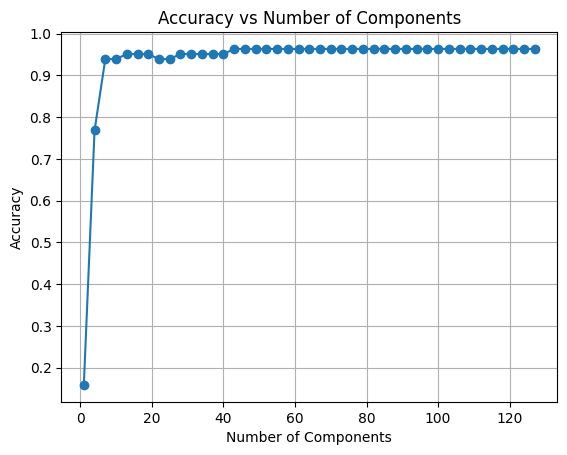

In [18]:
accuracies = pca_accuracy_plot(facematrix_centered, faceshape, step = 3, num_components=num_components, rs=0)

Como era de esperar, vemos un aumento creciente monótono en la `accuracy` hasta que llega al máximo y se queda estable.

## <a id='toc2_3_'></a>[KPCA](#toc0_)

### <a id='toc2_3_1_'></a>[Entrenamiento del modelo de KPCA](#toc0_)

- `Intenta aplicar el mismo procedimiento con KPCA (kernel lineal). Tendrás que hacer algunas traspuestas para conseguirlo.`

- Entrenamiento del modelo de KPCA.

In [19]:
# KPCA (Kernel PCA)
kpca = KernelPCA(kernel = "linear", fit_inverse_transform = True, random_state = rs, n_components = 50)
kpca.fit(facematrix_centered)

KernelPCA(fit_inverse_transform=True, n_components=50, random_state=0)

Con `KPCA()` no existe un método para mostrar las componentes en el espacio original como hacíamos con `PCA()`, por lo que no se puede representar las `eigenfaces` como tal.

### <a id='toc2_3_2_'></a>[Aplicación del modelo de KPCA a las imágenes de test](#toc0_)

In [20]:
def get_best_match_kpca(filename, kpca, plot = True, text = False):
    
    query = faces[filename].reshape(1, -1)
    
    kpca_train = kpca.transform(facematrix_centered)
    kpca_query = kpca.transform(query)  # Transformar la imagen de consulta al espacio de características de KPCA

    euclidean_distance = np.linalg.norm(kpca_query - kpca_train, axis=1)

    best_match = np.argmin(euclidean_distance)

    print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))

    person_num, img_num = get_person_num(filename=filename)

    if plot:
        fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))

        axes[0].imshow(query.reshape(faceshape), cmap="gray")
        axes[0].set_title("Query - Person " + str(person_num))
        axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
        axes[1].set_title("Best match - Person " + str((best_match // 8) + 1))
        plt.show()

    return (((best_match // 8) + 1), person_num)

In [21]:
# Evaluación de KPCA

correct_pred_kpca = 0
wrong_pred_kpca = 0
total_pred_kpca = 0

for key, val in testing_set.items():
    total_pred_kpca += 1

    predicted_kpca, actual_kpca = get_best_match_kpca(filename=key, kpca = kpca, plot=False, text = False)

    if predicted_kpca == actual_kpca:
        correct_pred_kpca += 1
    else:
        wrong_pred_kpca += 1

Best match (1, 5) with Euclidean distance 2019.371985
Best match (1, 7) with Euclidean distance 1895.461896
Best match (2, 3) with Euclidean distance 958.247412
Best match (2, 7) with Euclidean distance 812.612088
Best match (3, 3) with Euclidean distance 1348.839309
Best match (3, 9) with Euclidean distance 727.803363
Best match (4, 3) with Euclidean distance 962.652526
Best match (4, 5) with Euclidean distance 1076.874413
Best match (5, 4) with Euclidean distance 466.782068
Best match (40, 5) with Euclidean distance 1361.146669
Best match (6, 3) with Euclidean distance 608.217559
Best match (6, 4) with Euclidean distance 503.879096
Best match (7, 3) with Euclidean distance 805.071389
Best match (7, 5) with Euclidean distance 1013.217958
Best match (8, 2) with Euclidean distance 831.569672
Best match (8, 3) with Euclidean distance 993.025645
Best match (9, 3) with Euclidean distance 734.670500
Best match (9, 5) with Euclidean distance 1287.093100
Best match (38, 4) with Euclidean dist

In [22]:
Correct_Predic_KPCA, Wrong_Predic_KPCA, Accuracy_KPCA = get_stats(correct_pred_kpca, wrong_pred_kpca, total_pred_kpca)
print(f"Correct prediction with KPCA: ", Correct_Predic_KPCA)
print(f"Wrong prediction with KPCA: ", Wrong_Predic_KPCA)
print(f"Accuracy with KPCA: ", Accuracy_KPCA, "%")

Correct prediction with KPCA:  0.963
Wrong prediction with KPCA:  0.037
Accuracy with KPCA:  96.341 %


Obtenemos una `accuracy` igual que la del modelo de `PCA`, como era de esperar. El utilizar `kernel = 'linear'` hace que este se comporte igual que PCA.

In [23]:
def kpca_accuracy_plot(facematrix_centered, faceshape, step=3, num_components=50, rs=0):
    
    accuracies = {}
    
    for n in range(1, num_components + 1, step):
        
        kpca_bucle = KernelPCA(n_components=n, kernel='linear', random_state=rs)
        kpca_bucle.fit(facematrix_centered)

        correct_pred = 0
        wrong_pred = 0
        total_pred = 0

        for key, val in testing_set.items(): 
            total_pred += 1

            predicted, actual = get_best_match(filename=key, pca=kpca_bucle, plot=False, text=False)

            if predicted == actual:
                correct_pred += 1
            else:
                wrong_pred += 1

        accuracies[n] = correct_pred / total_pred
    
    plt.plot(list(accuracies.keys()), list(accuracies.values()), marker='o')
    plt.title('Accuracy vs Number of Components (Kernel PCA)')
    plt.xlabel('Number of Components')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
    
    return accuracies

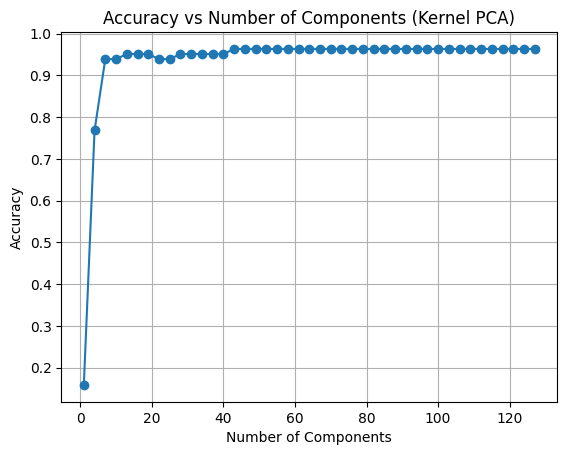

In [24]:
accuracies_kpca = kpca_accuracy_plot(facematrix_centered, faceshape, step = 3, num_components=num_components, rs=0)

La forma de `accuracy` según el número de componentes es idéntica a la de `PCA`, como era de esperar por el `kernel` utilizado.

## <a id='toc2_4_'></a>[Conclusiones](#toc0_)

En este proyecto se emplearon técnicas de análisis de componentes principales (PCA) y análisis de componentes principales kernelizado (KPCA) con kernel lineal para el reconocimiento facial en un conjunto de datos dividido en entrenamiento y prueba. 

A través de la generación y análisis de eigenfaces se evaluó la capacidad de ambos métodos para capturar y representar las características faciales distintivas. La comparación de la precisión de los modelos revela resultados idénticos entre PCA y KPCA, ya que el kernel utilizado fue el lineal.

De todas maneras, los resultados fueron muy satisfactorios: se obtuvo una predicción correcta de más de un 96 % de las caras de prueba.

No se ha incluido en aras de brevedad, pero estuvimos probando diferentes `kernel` para KernelPCA() como `poly` y `rbf` haciendo barridos paralelizados de hiperparámetros. 
Los resultados no fueron tan buenos como los lineales, por lo que en este caso consideramos que esta es la mejor opción (simpleza y efectividad).